In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import torch.nn as nn

_include_('curriculum_vqa')
_include_('commons')

seed = 1
np.random.seed(seed)
torch.manual_seed(seed);

from cvqa import datasets, models, trainers, viz
from commons import debug

data_bin = f'{DEV_HOME}/curriculum_vqa/data-bin'

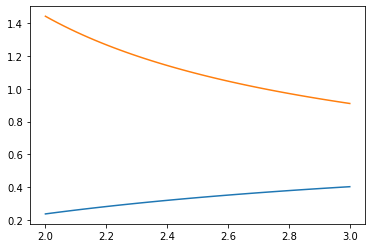

In [35]:
import matplotlib.pyplot as plt

x = np.linspace(2, 3)

f = 1/np.log(x)


plt.plot(x, np.exp(-f));
plt.plot(x, f)

In [3]:
torch.cat([
    torch.rand(5, 2),
    torch.rand(5, 5),
], dim=1)

tensor([[0.7576, 0.2793, 0.6387, 0.5247, 0.6826, 0.3051, 0.4635],
        [0.4031, 0.7347, 0.4550, 0.5725, 0.4980, 0.9371, 0.6556],
        [0.0293, 0.7999, 0.3138, 0.1980, 0.4162, 0.2843, 0.3398],
        [0.3971, 0.7544, 0.5239, 0.7981, 0.7718, 0.0112, 0.8100],
        [0.5695, 0.4388, 0.6397, 0.9743, 0.8300, 0.0444, 0.0246]])

In [8]:
a = torch.ones(5, 7)
a[:,1:] = 0
a

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])

In [20]:
mask = torch.zeros(5, dtype=torch.bool)
mask[1] = 1
mask[2] = 1
a[mask]

tensor([[1., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.]])

In [ ]:
y = torch.ones

## Basic Model Specification

Concepts (red, block, triangle)
* $c \in [C]$ denotes a Concept Symbol
* $v_c \in \mathbb R^{d_c}$ a concept vector
* $E_c \in \mathbb R^{d_c \times C}$ the concepts embedding matrix

Concept Categories (shape, color)
* $k \in [K]$ denotes a Concept Category (color, shape)
* $v_k \in \mathbb R^{d_k}$ a concept category vector
* $E_k \in \mathbb R^{d_k \times K}$ the concept categories embedding matrix

Relations (contains, below, above)
* $r \in [R]$ denotes a relational concept Symbol
* $v_r \in \mathbb R^{d_r}$ a concept vector
* $E_r \in \mathbb R^{d_r \times R}$ the relations embedding matrix



Others
* $o \in \mathbb R^{d_o}$ denotes a visual object.
* $Q \in \mathbb R^{d_o \times d_c \times d_k}$ - The concept operators matrix.


$ W_k = Q^\top v_k $

$k(o) = softmax(o^\top W_k)$  // Gives the concept distribution for category k (eg color) of object o (eg the 3rd object in the scene)

In [3]:
from torch.nn import functional as F

C = 100

B = 32

d = {
    'B': 32,
    
    'o': 16,
    'c': 40,
    'k': 4,
    'r': 25,
    'ak': 29,
    'av': 21,
    
    'w': 44,
    'a': 45,
    
    'N_o': 7,
    'N_p': 3
}

d_reversed = {v: k for k, v in d.items()}
def shape(t):
    return list(map(lambda dim: d_reversed.get(dim, dim), t.shape))
    
# shape(torch.rand(d['c'], d['o']))

In [4]:
E_c = torch.rand(C, d['c'])
W_kc = torch.rand(d['k'], d['c'])

C_ops = torch.rand(d['o'], d['c'], d['k'])
Q_ops = torch.rand(d['o'], d['a'], d['k'])

N_o = 7
N_p = 3
X = torch.rand(B, N_o, d['o'])
X_weights_in_1 = torch.ones(d['B'], d['N_o'])
X_weights_in_2 = torch.ones(d['B'], d['N_o'])
X_weights_in = X_weights_in_1


In [5]:
def get_op(op_seed, op_mat):
    """
    op_seed: [B, d_op]
    op_mat: [d_in, d_out, d_op]
    """
    d_in, d_out, d_op = op_mat.shape
    W = F.linear(op_seed, op_mat.reshape(-1, d_op))  # [B, d_out * d_in]
    
    return W.reshape(B, d_in, d_out)

In [6]:
# question_op = torch.rand(B, d['k'])

# W_answer = get_op(question_op, Q_ops)  # [B, o, a]
    
# weighted_X = torch.matmul(X_weights_in.unsqueeze(1), X).squeeze()  # [B, o]

# logits = torch.matmul(weighted_X.unsqueeze(1), W_answer)
# shape(logits)

In [7]:
def answer_module(X, X_weights_in, question_op):
    """
    X: [B, N_o, d_o]
    X_weights_in: [B, N_o]
    question_op: [B, d_k]
    """
    W_answer = get_op(question_op, Q_ops)  # [o, a]
    
    weighted_X = torch.matmul(X_weights_in.unsqueeze(1), X).squeeze()  # [B, o]
    
    logits = torch.matmul(weighted_X.unsqueeze(1), W_answer)
    return logits.squeeze()
    
shape(answer_module(X, X_weights_in_1, torch.rand(B, d['k'])))

['B', 'a']

In [8]:
def f1_module(X, X_weights_in, op):
    """
    X: [B, N_o, d_o]
    X_weights_in: [B, N_o]
    op: [B, d_c]
    """
    
    #### Concept Category Predicate

    # 1) op seed --> batch of concept ops
    P = op  # P for predicate 
    P_k = F.linear(P, W_kc)  # [B, d_k] P_k for predicate category (eg color)
    P_k = get_op(P_k, C_ops)  # [B, d_o, d_c]

    # 2) Apply derived concept op to each object
    X_c = torch.matmul(torch.rand(B, N_o, d['o']), P_k)  # [B, N_o, d_c]

    # 3) Compute cosine similarity in concept distribution space (is there a better way to do this?)
    X_c_probs = F.softmax(torch.matmul(X_c, E_c.T), dim=-1) # [B, N_o, C]
    P_c_probs = F.softmax(torch.matmul(P, E_c.T), dim=-1) # [B, C]
    XP_res = torch.sum(X_c_probs * P_c_probs.unsqueeze(1), dim=-1)  # [B, N_o], holds the probability every object passes the predicate

    
    #### Logical Not? Other Structures?
    return X_weights_in * XP_res

op1 = torch.rand(B, d['c'])
f1_res = f1_module(X, X_weights_in_1, op1)
shape(f1_res)

['B', 'N_o']

In [9]:
import math

def attention(query, key, value, mask_weights=None, dropout=None):
    """
    Copied and adjusted from the annotated transformer; https://nlp.seas.harvard.edu/2018/04/03/attention.html
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask_weights is not None:
        scores += mask_weights.unsqueeze(1).log()
        
    p_attn = F.softmax(scores, dim = -1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [10]:
A_ops_q = torch.rand(d['o'], d['ak'], d['r'])
A_ops_k = torch.rand(d['o'], d['ak'], d['r'])
A_ops_v = torch.rand(d['o'], d['av'], d['r'])

A_W_res = torch.rand(d['av'], 2)

# rel_op = torch.rand(B, d['r'])
# W_q = get_op(rel_op, A_ops_q)
# W_k = get_op(rel_op, A_ops_k)
# W_v = get_op(rel_op, A_ops_v)


# Q = torch.matmul(X, W_q)
# K = torch.matmul(X, W_k)
# V = torch.matmul(X, W_v)

# X_weights_in_1 = torch.ones(d['B'], d['N_o'])
# X_weights_in_2 = torch.ones(d['B'], d['N_o'])

# shape(Q)

In [11]:
# att_res, p_att = attention(Q, K, V, X_weights_in_2)

# shape(att_res)

# res = F.softmax(F.linear(att_res, A_W_res.T), dim=-1)
# shape(res[:, :, 0])

In [12]:
def f2_module(X, X_weights_in_1, X_weights_in_2, rel_op):
    """
    X: [B, N_o, d_o]
    X_weights_in_1, X_weights_in_2: [B, N_o]
    rel_op: [B, d_r]
    """
    
    # 1) op seed --> batch of attention parameters matrices
    W_q = get_op(rel_op, A_ops_q)
    W_k = get_op(rel_op, A_ops_k)
    W_v = get_op(rel_op, A_ops_v)

    Q = torch.matmul(X, W_q)
    K = torch.matmul(X, W_k)
    V = torch.matmul(X, W_v)
    
#     Q = Q * X_weights_in_1
    
    att_res, p_att = attention(Q, K, V, X_weights_in_2)
    res = F.softmax(F.linear(att_res, A_W_res.T), dim=-1)
    return res[:, :, 0] * X_weights_in_1



rel_op = torch.rand(B, d['r'])

f2_res = f2_module(X, X_weights_in_1, X_weights_in_2, rel_op)
shape(f2_res)

['B', 'N_o']

In [13]:
# predicate = torch.rand(B, N_p, d_c)


# def apply_predicate(X, P):
#     # objects concepts index
#     X_ck = torch.matmul(X.unsqueeze(1), Q)  # [B, d_c, N_o, d_k]
#     X_ck = X_ck.transpose(1, 2) # [B, N_o, d_c, d_k]

#     # predicate to categories
#     P_k = F.linear(P, W_kc)  # [B, N_p, d_k]
#     P_k = P_k.transpose(1, 2)  # [B, d_k, N_p]

#     # [B, N_o, d_c, d_k]
#     # [B, 1, d_k, N_p]

#     X_pc = torch.matmul(X_ck, P_k.unsqueeze(1)) # [B, N_o, d_c, N_p]
#     X_pc = X_pc.transpose(2, 3)  # [B, N_o, N_p, d_c]

#     X_res = F.softmax(torch.matmul(X_pc, E_c.T), dim=-1) # [B, N_o, N_p, C]
#     p_res = F.softmax(torch.matmul(P, E_c.T), dim=-1) # [B, N_p, C]

#     # X_res holds O x P --> scores
#     # p_res holds P --> scores

#     return torch.prod((X_res * p_res.unsqueeze(1)).sum(dim=-1), dim=-1)

# apply_predicate(X, predicate).shape

In [ ]:
# define attributes and their values
# to sample an object, sum a few descriptive tokens and scramble by a random transformation
# sample a set of N objects
# sample attention mask pattern
# Questions:
#     How many {P}
#     Is there a {P}
#     Is there no {P}
#     What color/shape/etc
    

In [1]:
# Get some word embeddings # 1h
# Define attrs --> values # 1h
# object sampler # 2h
# 

In [25]:
import torch
import itertools
from torchnlp.encoders.text import WhitespaceEncoder
from torchnlp.word_to_vector import GloVe

concept_dict = {
    'shape': ['triangle', 'circle', 'square'],
    'color': ['blue', 'brown', 'cyan', 'gray', 'green', 'purple', 'red', 'yellow'],
    'material': ['metal', 'rubber']
}

concept_keys = list(concept_dict.keys())
concept_values = list(itertools.chain(*concept_dict.values()))


encoder = WhitespaceEncoder(concept_keys + concept_values)
vocab_set = set(encoder.vocab)

In [26]:
pretrained_embedding = GloVe(name='6B', dim=100, is_include=lambda w: w in vocab_set)
embedding_weights = torch.Tensor(encoder.vocab_size, pretrained_embedding.dim)
for i, token in enumerate(encoder.vocab):
    embedding_weights[i] = pretrained_embedding[token]

100%|██████████| 400000/400000 [00:02<00:00, 149225.72it/s]


In [28]:
# To compute a good representation, we want all attributes to be easily queryable;

# X[K, d] -> W_enc -> x_vec[o] -> W_dec -> [K, N_c]

In [31]:
import random

random.choice(concept_dict['shape'])
encoder.encode('circle')

tensor([9])

In [48]:
N = 500
objects = []
for i in range(N):
    obj = []
    for ck in concept_dict:
        cv = random.choice(concept_dict[ck])
        c_id = encoder.encode(cv)
        obj.append(c_id)
    objects.append(torch.cat(obj))
    
y = torch.stack(objects)
X = embedding_weights[y]

In [50]:
ds = torch.utils.data.TensorDataset(X, y)
for e in range(10):
    for i, s in torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True):
        

torch.Size([3, 100])

In [ ]:
d = 
torch.nn.Sequential(
    nn.Linear()
)